## LSTM Kullanarak İstanbul Hava Kirliliği Tahmin Modeli

Gerekli kütüphaneleri import ettik.

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas import concat
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
from datetime import datetime

Dataseti import ettik.

In [2]:
df = pd.read_csv('data/dataframe.csv')
df = df[["ReadTime", "Name", "AQIIndex"]]
df.head()

,ReadTime,Name,AQIIndex
0,2019-10-01T00:00:00,Maslak,48.0
1,2019-10-01T01:00:00,Maslak,51.0
2,2019-10-01T02:00:00,Maslak,53.0
3,2019-10-01T03:00:00,Maslak,53.0
4,2019-10-01T04:00:00,Maslak,55.0


Zaman sütununu datatime ile zaman tipine çevirdik.

In [3]:
df["ReadTime"] = pd.to_datetime(df['ReadTime'], format='%Y-%m-%dT%H:%M:%S')

In [4]:
df['AQIIndex'] = df['AQIIndex'].apply(lambda x: None if x=='None' else x) #'None' değerleri python'ın algılayabileceği şekilde çevrildi
df['AQIIndex'] = df['AQIIndex'].astype(float)
df = df[df["Name"]!="Beylikdüzü"] #Beylikdüzü'nde tüm değerler NAN olduğu için dropladık.

NAN olan değerler için o ilçenin ortalama değerini koyarak boş değerleri doldurmuş olduk.

In [5]:
aqi_ortalama = df.groupby(by=["Name"]).mean().reset_index()

In [6]:
for index, row in df.iterrows():
    if pd.isna(row['AQIIndex']):
        df.at[index,'AQIIndex'] = aqi_ortalama[row['Name']==aqi_ortalama['Name']]["AQIIndex"]

Datasetini modele sokabilmek için gerekli düzenlemeler yaptık.

In [7]:
df = pd.concat([df, df["ReadTime"].dt.isocalendar()], axis=1)

In [8]:
df = df.groupby(["Name","week"])["AQIIndex"].mean().reset_index()

In [9]:
df.drop(["Name", "week"], axis=1, inplace=True)

Modelin daha iyi sonuç vermesi için değerlerin e tabanında logaritmasını alarak sütunu normalleştirmiş olduk.

In [10]:
df['AQIIndex'] = df['AQIIndex'].apply(lambda x: np.log(x))

In [11]:
dataset = df.values

Verisetinin %80'ini train ve %20'sini de test olarak ayırdık. Böylece, datasetimizin 820 satırı train, 206 satırı test olarak ayrıldı.

In [12]:
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(df),:]

Zaman serisi olarak bir model kurmak istediğimiz için, bir önceki zaman adımının bir sütun olarak dataya eklenmesini sağlayacak bir fonkisyon oluşturduk.

In [13]:
def onceki_adim(dataset, adim_sayisi=1):
    x = []
    y = []

    for i in range(len(dataset)-adim_sayisi-1):
        adim = dataset[i:(i+adim_sayisi), 0]
        x.append(adim)
        y.append(dataset[i+adim_sayisi, 0])
        
    return np.array(x), np.array(y)

Geriye bakılacak zaman adımı sayısı olarak 6 belirledik. Bu sayede, geriye dönük 6 saati bir satır olarak almış olduk. Daha sonrasında üstte oluşturduğumuz fonksiyonu train ve test verisetlerine uyguladık.

In [14]:
adim_sayisi = 4

trainX, trainY = onceki_adim(train, adim_sayisi)
testX, testY = onceki_adim(test, adim_sayisi)

LSTM, veriyi (rows, timesteps, features) şeklinde 3 boyutlu argüman kabul ettiği için reshape yaptık.

In [15]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1])) 
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Keras kütüphanesini kullanarak LSTM modelini oluşturduk. Modelleri katman katman oluşturmak için kullanılan Sequential() adlı fonksiyonu kullandık. Modelimize katman eklemek için de add fonksiyonunu kullandık.

In [16]:
model = Sequential()
model.add(LSTM(32, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4736      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________


Öğrenme sırasında validation loss ile test loss arasındaki fark açılmaya başladığı durumda model ezberliyor (overfitting) ya da gürültüyü öğreniyor (noisy) demektir. EarlyStopping fonksiyonu bu durumlar yaşanmaması için val_loss yükselmeye başladığında öğrenmeyi durduruyor.

In [17]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [18]:
history = model.fit(trainX, trainY, validation_data=(testX, testY), verbose=1, epochs=1000, batch_size=None, shuffle=False, callbacks=[es])

Epoch 1/1000
26/26 [==============================] - 5s 42ms/step - loss: 7.0663 - val_loss: 4.5652
Epoch 2/1000
26/26 [==============================] - 0s 7ms/step - loss: 2.8719 - val_loss: 1.3410
Epoch 3/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.6971 - val_loss: 0.2008
Epoch 4/1000
26/26 [==============================] - 0s 8ms/step - loss: 0.1489 - val_loss: 0.0737
Epoch 5/1000
26/26 [==============================] - 0s 9ms/step - loss: 0.1116 - val_loss: 0.0743
Epoch 6/1000
26/26 [==============================] - 0s 8ms/step - loss: 0.1105 - val_loss: 0.0734
Epoch 7/1000
26/26 [==============================] - 0s 9ms/step - loss: 0.1099 - val_loss: 0.0733
Epoch 8/1000
26/26 [==============================] - 0s 8ms/step - loss: 0.1097 - val_loss: 0.0731
Epoch 9/1000
26/26 [==============================] - 0s 8ms/step - loss: 0.1094 - val_loss: 0.0730
Epoch 10/1000
26/26 [==============================] - 0s 8ms/step - loss: 0.1090 - val_loss: 0.072

26/26 [==============================] - 0s 8ms/step - loss: 0.0935 - val_loss: 0.0668
Epoch 83/1000
26/26 [==============================] - 0s 9ms/step - loss: 0.0935 - val_loss: 0.0668
Epoch 84/1000
26/26 [==============================] - 0s 8ms/step - loss: 0.0934 - val_loss: 0.0668
Epoch 85/1000
26/26 [==============================] - 0s 7ms/step - loss: 0.0934 - val_loss: 0.0668
Epoch 85: early stopping


In [19]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

Başlangıçta scale ettiğimiz değerleri eski haline çevirdik.

In [20]:
trainPredict = math.e**trainPredict
trainY = math.e**trainY
testPredict = math.e**testPredict
testY = math.e**testY

Modelin trainX kullanarak trainY'yi hesapladı ve hatalarının karelerinin toplamının karekökünü hesapladık. Aynısını testX ve testY için de yaptık.

In [21]:
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Skoru: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Skoru: %.2f RMSE' % (testScore))

Train Skoru: 10.91 RMSE
Test Skoru: 9.65 RMSE


Çizdirdiğimiz grafikte mavi çizgi gerçek değerleri gösterirken, turuncu çizgi trainY tahmin değerlerini, yeşil çizgi ise testY tahmin değerlerini gösteriyor.

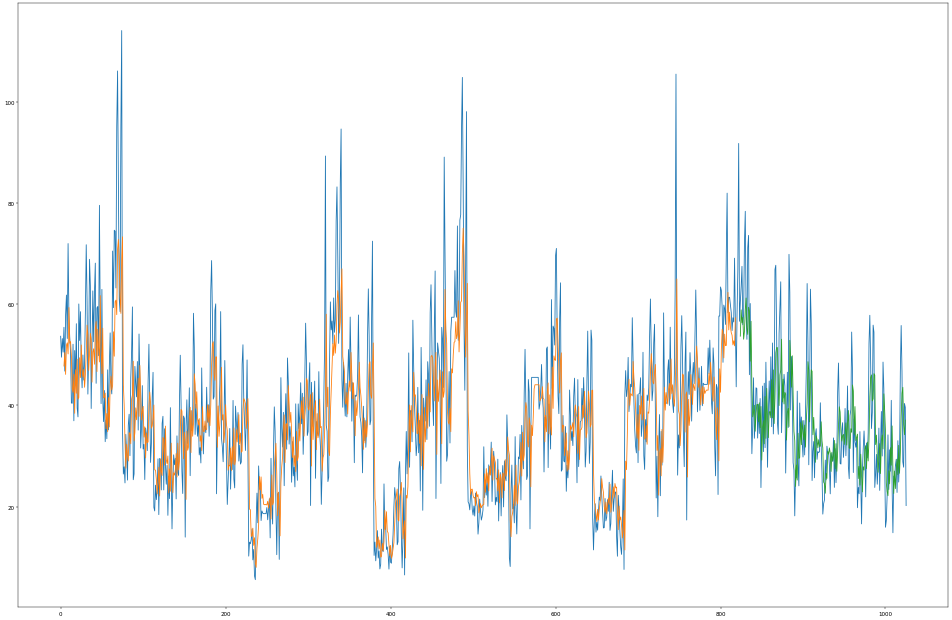

In [22]:
dataset = math.e**dataset

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[adim_sayisi:len(trainPredict)+adim_sayisi, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(adim_sayisi*2)+1:len(dataset)-1, :] = testPredict

plt.figure(figsize=(30, 20), dpi=40)
plt.plot(dataset)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Örneğin, elimizde 1 aylık veri olsaydı model gelecek ayın ilk haftasını şu şekilde tahmin ederdi:

In [25]:
degerler= [30, 25, 16, 24]

degerler_scaled = np.log(degerler)

degerler_scaled = degerler_scaled.reshape(1,1,4)
degerlerPredict = model.predict(degerler_scaled)

print(math.e**degerlerPredict)

[[25.81814]]


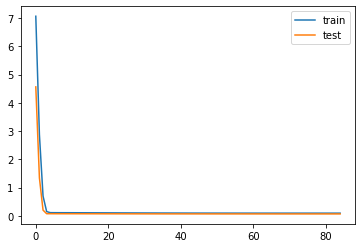

In [26]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [34]:
testPredict=pd.DataFrame(testPredict)
testY=pd.DataFrame(testY)
x=pd.concat((testPredict , testY),axis=1)
x.columns = ["Tahmin Değerleri","Gerçek Değerler"]
x

,Tahmin Değerleri,Gerçek Değerler
0,53.688484,60.410714
1,58.880581,63.464286
2,56.291294,67.476190
3,57.437515,55.946429
4,53.081444,57.886905
...,...,...
196,42.381870,46.702381
197,43.584816,28.863095
198,36.186760,27.797619
199,34.218788,40.392857
